<a href="https://colab.research.google.com/github/Olshansk/pockenomics/blob/main/GREAT_VIBES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This model was co-developed by Adam and Olshansky while [PUP-15](https://forum.pokt.network/t/pup-15-good-vibes-a-new-economic-policy-for-pocket-network/3037/35).

Though this model is more elegant and potentially more applicable in the future when market conditions change, or in V1 when additional protocol level actors are introduced, please note that it is more complex and requires more discussion and peer-review before adoption.

For that reason, if you are reading/reviewing this, see this as a mid or long term solution.

# Target Validator Stake

This model aims to set a target validator stake in order to secure the network. 

Intentional biproducts taken into consideration is the goal of optimizing the number of nodes on the network, while not limiting its growth.

**Example**

Assume there is a total of 100 POKT staked on the network.

A `target_val_stake` of 0.8 would imply:
* **80 POKT** is staked across all of the validators (in total)
* **20 POKT** is staked across all of the servicers (in total)

## Sigmoid

In order to create a smooth and elegant incentive curve with GREAT VIBES, we a sigmoid function is used:

$y = \frac{a}{1 + e^{-b(x-c)}} + d$ 

where:

* `a ∈ [0, 1]`: % range (min and max) of the validator rewards; this is named `validator_allocation_range_a`
* `b ∈ (0, ∞)`: Parameter determining the steepness of the curve; `curve_steepness_b`
* `c ∈ (0, 1]`: % target validator stake; `target_val_stake_c`
* `d ∈ [0, 1]`: % min validator allocation of total rewards; `min_val_allocation_d` 

Note that we are ommitting some complexities encapuslated by the computation below. For example, a + d cannot exceed 1.

If approved, c & d would be parameters variables set, and periodically modified, by the DAO whereas a & b are likely to remain constants, though still configurable, based on the community's discussion.

*Unnecessary context for the keen: sigmoid functions are often used for data normalization in data science.**

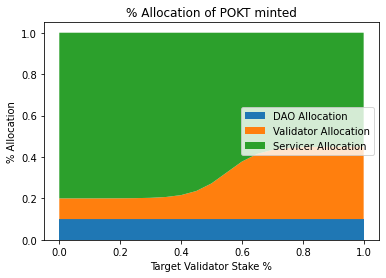

In [ ]:
# @title % Allocation distribution example

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

validator_allocation_range_a = 0.25 #@param {type:"slider", min:0, max:1, step:0.05}
curve_steepness_b = 18 #@param {type:"slider", min:0, max:50, step:2}
target_val_stake_c = 0.55 #@param {type:"slider", min:0, max:1, step:0.05}
min_val_allocation_d = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}
dao_allocation = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

assert target_val_stake_c != 0, "target_val_stake_c cannot equal 0"
assert (validator_allocation_range_a + min_val_allocation_d + dao_allocation) <= 1, "ERROR: validator_allocation_range_a + min_val_allocation_d + dao_allocation CANNOT exceed 1"

a = validator_allocation_range_a
b = curve_steepness_b
c = target_val_stake_c
d = min_val_allocation_d

target_val_stake = np.linspace(0, 1.0, 21)
dao_allocation = np.repeat(dao_allocation, len(target_val_stake))
val_allocation = a / (1 + np.exp(-b * (target_val_stake - c))) + d
servicer_allocation = 1 - val_allocation - dao_allocation

plt.stackplot(target_val_stake, dao_allocation, val_allocation, servicer_allocation, labels=['DAO Allocation', 'Validator Allocation', 'Servicer Allocation'])
plt.legend(loc='right')
plt.xlabel('Target Validator Stake %')
plt.ylabel('% Allocation')
plt.title('% Allocation of POKT minted')
plt.show()    

# Network Params & Variables

In addition to the variables above, there are several other parameters that need to be taken into consideration.

* `num_validators`: The number of validators should be sufficiently high so as to increase security, but not too high due to technical limitations. This is set by the DAO.
* `pokt_per_servicer`: the minimum amount of POKT a servicer or validator needs to stake. 
  * Note that servicers have no incentive to stake far beyond the minimum to earn rewards and are therefore assumed to stake the min in this analysis. However, validators are selected based on a weighted round-robin algorithm from the top 1,000 list and therefore have an incentive to periodically "top-up".
* `num_nodes`: The total number of nodes (validators & servicers) staked on the network. This will vary based on market conditions, supply & demand curves, as well as the incentivization curves.
* `total_pokt_staked`: The total number of POKT staked on the network. This will vary based on the number of nodes, market conditions, supply & demand curves, as well as the incentivization curves.
   * Please note that for each servicer that is added / removed on the network, anywhere between 0 and `pokt_per_servicer` will be added / removed to the network.
* `INFLATION_PER_NODE`: Out of scope for this discussion. Based on WAGMI, this is approximated to 14000 / node staked on the network.


(47150.0, -150.0)

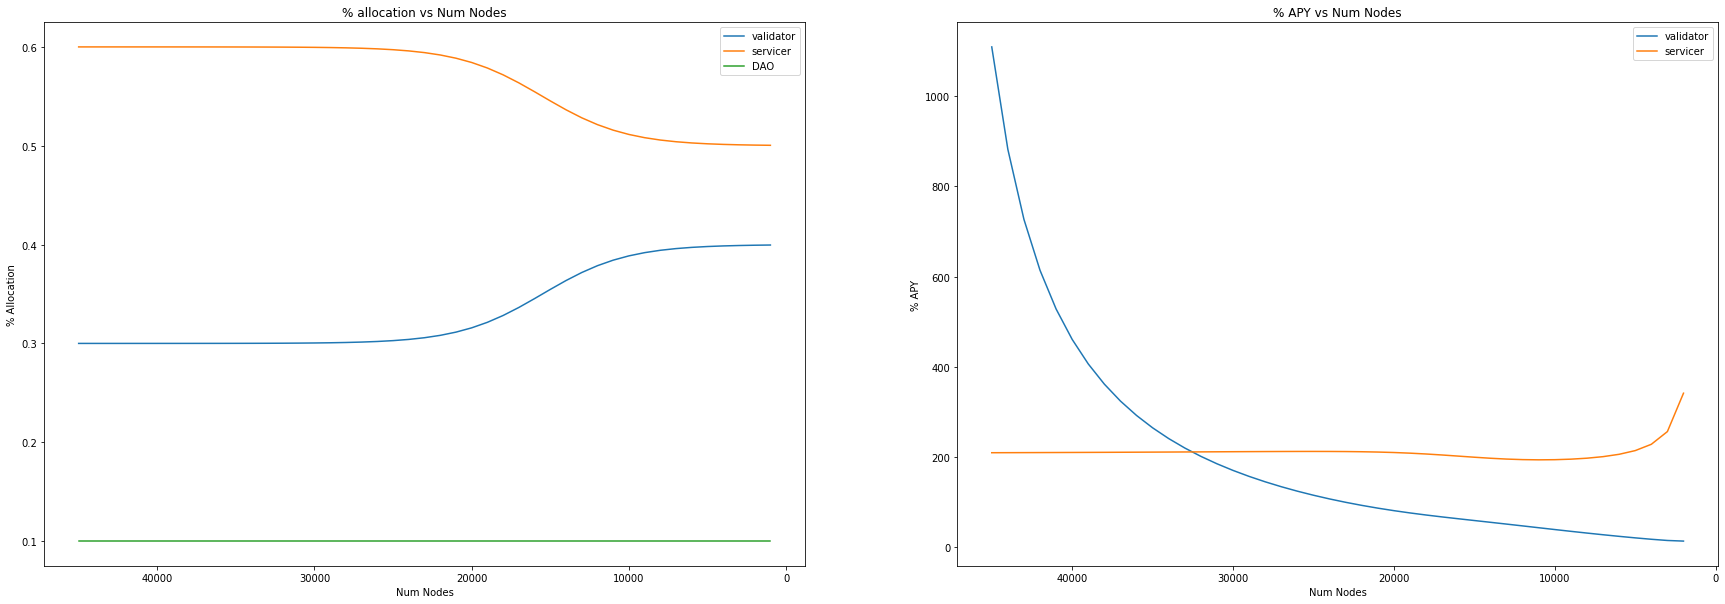

In [ ]:
#@title Basic example of % APY with variable parameters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

INFLATION_PER_NODE = 14000 # An approximative takeaway from WAGMIi

validator_allocation_range_a = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
curve_steepness_b = 18 #@param {type:"slider", min:0, max:50, step:2}
target_val_stake_c = 0.7 #@param {type:"slider", min:0, max:1, step:0.05}
min_val_allocation_d = 0.3 #@param {type:"slider", min:0, max:1, step:0.1}
dao_allocation = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

assert target_val_stake_c != 0, "target_val_stake_c cannot equal 0"
assert (validator_allocation_range_a + min_val_allocation_d + dao_allocation) <= 1, "ERROR: validator_allocation_range_a + min_val_allocation_d + dao_allocation CANNOT exceed 1"

a = validator_allocation_range_a
b = curve_steepness_b
c = target_val_stake_c
d = min_val_allocation_d

pokt_staked = 725000000  #@param {type:"slider", min:100000000, max:1000000000, step:0.1}
num_vals = 1000  #@param {type:"slider", min:500, max:5000, step:500}
pokt_per_servicer = 15000 #@param {type:"slider", min:10000, max:20000, step:1000}

def easy_linspace(start, step, num):
    return start + np.arange(0,num)*step

num_nodes = easy_linspace(1000, 1000, 45)

columns = [
    'target_inflation', 'pokt_staked', 'num_nodes', 'val_power',
    'num_vals', 'avg_stake_per_val', 'total_val_stake', 'val_allocation', 'pokt_per_val_only',  'pokt_per_val', 'val_apy',
    'num_serv', 'avg_stake_per_serv', 'total_srv_stake', 'serv_allocation', 'pokt_per_serv',  'serv_apy']

df = pd.DataFrame(columns=columns)
df['num_nodes'] = num_nodes
df['pokt_staked'] = pokt_staked
df['target_inflation'] = INFLATION_PER_NODE * df['num_nodes']

df['num_vals'] = num_vals
df['num_serv'] = df['num_nodes'] - df['num_vals']

df['avg_stake_per_serv'] = pokt_per_servicer
df['total_srv_stake'] = df['num_serv'] * df['avg_stake_per_serv']

df['avg_stake_per_val'] = (df['pokt_staked'] - df['num_serv'] * df['avg_stake_per_serv']) / df['num_vals']
df['total_val_stake'] = df['num_vals'] * df['avg_stake_per_val']

df['val_power'] = df['total_val_stake'] / df['pokt_staked']

df['val_allocation'] = a / (1 + np.exp(-b * (df['val_power'] - c))) + d
df['serv_allocation'] = 1 - df['val_allocation'] - dao_allocation
df['dao_allocation'] = dao_allocation

df['pokt_per_serv'] = df['serv_allocation'] * df['target_inflation'] / df['num_serv']
df['pokt_per_val_only'] = df['val_allocation'] * df['target_inflation'] / df['num_vals']
df['pokt_per_val'] = df['pokt_per_serv'] + df['pokt_per_val_only']

df['val_apy'] = df['pokt_per_val'] * 365 / df['avg_stake_per_val']
df['serv_apy'] = df['pokt_per_serv'] * 365 / df['avg_stake_per_serv']


graph, (plot1, plot2) = plt.subplots(1, 2, figsize=(30,10))

plot1.plot(df['num_nodes'], df['val_allocation'], label='validator')
plot1.plot(df['num_nodes'], df['serv_allocation'], label='servicer')
plot1.plot(df['num_nodes'], df['dao_allocation'], label='DAO')
plot1.legend()
plot1.set_xlabel('Num Nodes')
plot1.set_ylabel('% Allocation')
plot1.set_title('% allocation vs Num Nodes')
# Invert
xmin, xmax = plot1.get_xlim()
plot1.set_xlim(xmax, xmin)

plot2.plot(df['num_nodes'], df['val_apy'], label='validator')
plot2.plot(df['num_nodes'], df['serv_apy'], label='servicer')
plot2.legend()
plot2.set_xlabel('Num Nodes')
plot2.set_ylabel('% APY')
plot2.set_title('% APY vs Num Nodes')
# Invert
xmin, xmax = plot2.get_xlim()
plot2.set_xlim(xmax, xmin)

# pd.set_option('display.max_rows', 10)
# display(df)

# What are we optimizing for?

Looking at the `Ideal % APY vs Num Nodes` graph below, it shows the general curve we are aiming for:

* **When the number of nodes is high** => we are incentivizing the network to contract and move POKT from servicers to validators because we have a small number of validators maintaining the securiry of a high number of servicers until some point.
* **When the number of nodes is low** => we are incentivizing the network to expand and move POKT from validators to servicers because we have a small number of validators maintaining the securiry of a small number of servicers until some point.

Note that there is no target number of nodes on the network, but rather a `target_val_stake_c` to achieve some level of security, alongside other internal, external, rationale and irrational paramters.

Assuming this logic holds, the cost function we are trying to optimize for is the delta between the ideal validator APY and the ideal servicer APY.

[OLSHANSKY STILL THINKING] How did we draw this?
* We used a sigmoid to draw the ideal % APY for the "ideal curve"
* In our modelling, we used a sigmoid to draw out the "% validator allocation"
* The falacy is that we are using the "S curve" in for two different things between the marketing variables and our goal result.

## New parameter: percent_unstaked_pokt_remaining
Introducing `percent_unstaked_pokt_remaining`: For every servicer that is unstaked, how much of the POKT unstaked remains in the network (i.e. is moved to a validator).

For example, if a servicers with 15000 POKT staked is unstaked:
* Is 7500 moved to a validator 7500 is either HODLed / sold?
* Is all 15000 moved to a validator?
* Is all 15000 HODLed / sold?

This is too hard to determine and is a function of many paramters, so is therefore added as an additional nob for modeling purposes but is impossible to predict due to both rationale and irrationale inputs.

# TRY IT YOURSELF!

Move around the sliders yourself and see what the different curves look like to see if there's a configuration you think makes sense for the network.

If you have any additional ideas for new graphs togglers/sliders, graphs or find
issues, reach out to pikpokt#1217 or Olshansky#4187 on discord. Even better, submit a PR on Github [TODO here](TODO).

Note a few things. Due to the limitations of colab, we can't dynamically change the range on the sliders depending on the value, so please look at the error outputted if you hit an issue.

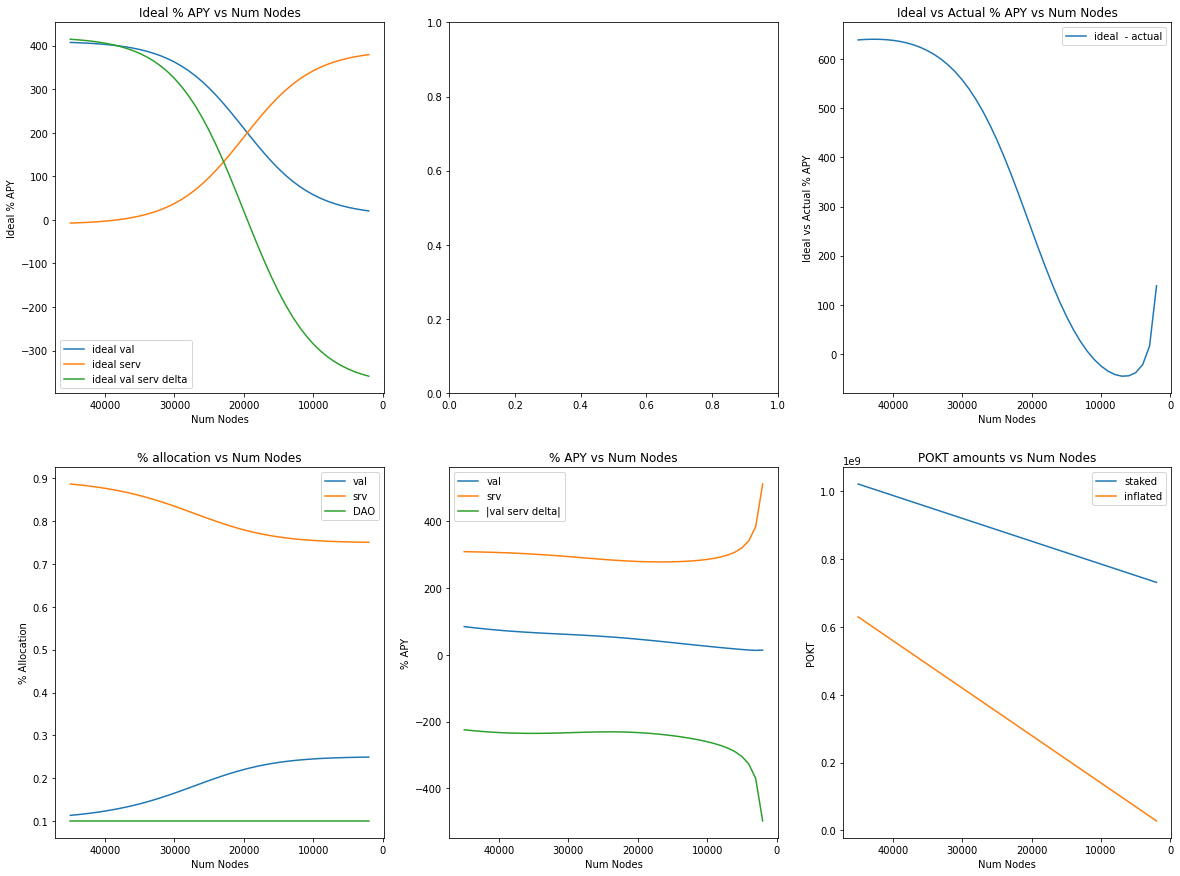

In [ ]:
#@title What are we optimizing for?

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

INFLATION_PER_NODE = 14000 # An approximative takeaway from WAGMIi

validator_allocation_range_a = 0.15 #@param {type:"slider", min:0, max:1, step:0.05}
curve_steepness_b = 12 #@param {type:"slider", min:0, max:50, step:2}
target_val_stake_c = 0.55 #@param {type:"slider", min:0, max:1, step:0.05}
min_val_allocation_d = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}
dao_allocation = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}

assert target_val_stake_c != 0, "target_val_stake_c cannot equal 0"
assert (validator_allocation_range_a + min_val_allocation_d + dao_allocation) <= 1, "ERROR: validator_allocation_range_a + min_val_allocation_d + dao_allocation CANNOT exceed 1"

a = validator_allocation_range_a
b = curve_steepness_b
c = target_val_stake_c
d = min_val_allocation_d

pokt_staked = 725000000  #@param {type:"slider", min:100000000, max:1000000000, step:0.1}
num_vals = 1000  #@param {type:"slider", min:500, max:5000, step:500}
pokt_per_servicer = 15000 #@param {type:"slider", min:10000, max:20000, step:1000}
percent_unstaked_pokt_remaining = 0.45  #@param {type:"slider", min:0, max:1, step:0.05}

def easy_linspace(start, step, num):
    return start + np.arange(0,num)*step

num_nodes = easy_linspace(1000, 1000, 45)

# Ideal val APY Model params: y = a / (1 + e^-b*(x-c)) + d
ideal_val_a = 400
ideal_val_b = 0.0002
ideal_val_c = 20000
ideal_val_d = 10

# Variable params
num_nodes = easy_linspace(1000, 1000, 45)

def get_df(
    num_nodes, initial_pokt_staked, pokt_per_servicer, percent_unstaked_pokt_remaining, inflation_per_node, num_vals,
    a, b, c, d,
    ideal_val_a, ideal_val_b, ideal_val_c, ideal_val_d,
):
    columns = [
        'target_inflation', 'pokt_staked', 'num_nodes', 'val_power',
        'num_vals', 'avg_stake_per_val', 'total_val_stake', 'val_allocation', 'pokt_per_val_only',  'pokt_per_val', 'val_apy',
        'num_serv', 'avg_stake_per_serv', 'total_srv_stake', 'serv_allocation', 'pokt_per_serv',  'serv_apy']
    df = pd.DataFrame(columns=columns)

    initial_num_nodes = num_nodes[0]
    df['num_nodes'] = num_nodes
    df['pokt_staked'] = initial_pokt_staked - (initial_num_nodes - df['num_nodes']) * pokt_per_servicer * percent_unstaked_pokt_remaining
    df['target_inflation'] = inflation_per_node * df['num_nodes']

    df['num_vals'] = num_vals
    df['num_serv'] = df['num_nodes'] - df['num_vals']

    df['avg_stake_per_serv'] = pokt_per_servicer
    df['total_srv_stake'] = df['num_serv'] * df['avg_stake_per_serv']

    df['avg_stake_per_val'] = (df['pokt_staked'] - df['num_serv'] * df['avg_stake_per_serv']) / df['num_vals']
    df['total_val_stake'] = df['num_vals'] * df['avg_stake_per_val']

    df['val_power'] = df['total_val_stake'] / df['pokt_staked']

    df['val_allocation'] = a / (1 + np.exp(-b * (df['val_power'] - c))) + d
    df['serv_allocation'] = 1 - df['val_allocation']
    df['dao_allocation'] = dao_allocation

    df['pokt_per_serv'] = df['serv_allocation'] * df['target_inflation'] / df['num_serv']
    df['pokt_per_val_only'] = df['val_allocation'] * df['target_inflation'] / df['num_vals']
    df['pokt_per_val'] = df['pokt_per_serv'] + df['pokt_per_val_only']

    df['ideal_val_apy'] = ideal_val_a / (1 + np.exp(-ideal_val_b * (df['num_nodes'] - ideal_val_c))) + ideal_val_d
    df['ideal_serv_apy'] = - df['ideal_val_apy'] + ideal_val_a
    # df['ideal_val_serv_delta_apy'] = abs(df['ideal_val_apy'] - df['ideal_serv_apy'])
    df['ideal_val_serv_delta_apy'] = df['ideal_val_apy'] - df['ideal_serv_apy']

    df['val_apy'] = df['pokt_per_val'] * 365 / df['avg_stake_per_val']
    df['serv_apy'] = df['pokt_per_serv'] * 365 / df['avg_stake_per_serv']
    # df['val_serv_delta_apy'] = abs(df['val_apy'] - df['serv_apy'])
    df['val_serv_delta_apy'] = df['val_apy'] - df['serv_apy']

    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

    return df

def plot(df):
    graph, ((plot1, plot2, plot3), (plot4, plot5, plot6)) = plt.subplots(2, 3, figsize=(20,15))

    plot1.plot(df['num_nodes'], df['ideal_val_apy'], label='ideal val')
    plot1.plot(df['num_nodes'], df['ideal_serv_apy'], label='ideal serv')
    # plot1.plot(df['num_nodes'], df['ideal_val_serv_delta_apy'], label='|ideal val serv delta|')
    plot1.plot(df['num_nodes'], df['ideal_val_serv_delta_apy'], label='ideal val serv delta')
    plot1.legend()
    plot1.set_xlabel('Num Nodes')
    plot1.set_ylabel('Ideal % APY')
    plot1.set_title('Ideal % APY vs Num Nodes')
    # Invert
    xmin, xmax = plot1.get_xlim()
    plot1.set_xlim(xmax, xmin)

    # plot3.plot(df['num_nodes'], df['ideal_val_serv_delta_apy'] - df['val_serv_delta_apy'], label='|ideal  - actual|')
    plot3.plot(df['num_nodes'], df['ideal_val_serv_delta_apy'] - df['val_serv_delta_apy'], label='ideal  - actual')
    plot3.legend()
    plot3.set_xlabel('Num Nodes')
    plot3.set_ylabel('Ideal vs Actual % APY')
    plot3.set_title('Ideal vs Actual % APY vs Num Nodes')
    # Invert
    xmin, xmax = plot3.get_xlim()
    plot3.set_xlim(xmax, xmin)    

    plot4.plot(df['num_nodes'], df['val_allocation'], label='val')
    plot4.plot(df['num_nodes'], df['serv_allocation'], label='srv')
    plot4.plot(df['num_nodes'], df['dao_allocation'], label='DAO')
    plot4.legend()
    plot4.set_xlabel('Num Nodes')
    plot4.set_ylabel('% Allocation')
    plot4.set_title('% allocation vs Num Nodes')
    # Invert
    xmin, xmax = plot4.get_xlim()
    plot4.set_xlim(xmax, xmin)

    plot5.plot(df['num_nodes'], df['val_apy'], label='val')
    plot5.plot(df['num_nodes'], df['serv_apy'], label='srv')
    plot5.plot(df['num_nodes'], df['val_serv_delta_apy'], label='|val serv delta|')
    plot5.legend()
    plot5.set_xlabel('Num Nodes')
    plot5.set_ylabel('% APY')
    plot5.set_title('% APY vs Num Nodes')
    # Invert
    xmin, xmax = plot5.get_xlim()
    plot5.set_xlim(xmax, xmin)

    plot6.plot(df['num_nodes'], df['pokt_staked'], label='staked')
    plot6.plot(df['num_nodes'], df['target_inflation'], label='inflated')
    plot6.legend()
    plot6.set_xlabel('Num Nodes')
    plot6.set_ylabel('POKT')
    plot6.set_title('POKT amounts vs Num Nodes')
    # Invert
    xmin, xmax = plot6.get_xlim()
    plot6.set_xlim(xmax, xmin)

df = get_df(
    num_nodes, pokt_staked, pokt_per_servicer, percent_unstaked_pokt_remaining, INFLATION_PER_NODE, num_vals,
    a, b, c, d,
    ideal_val_a, ideal_val_b, ideal_val_c, ideal_val_d, 
    )
plot(df)

# DANGER ZONE!

When it comes to finding the perfect network parametesr, it's more than an art than a science. There are rationale and irrationale actors in the network, external macro contributions, experience and knowledge of the Pocket ecosystem, etc...

In the section below, we are using a basic root-mean-square approach to find the "optimal" paramters, but it is still experimental. Suggestions, ideas, PRs, are welcome.


158.00753495654638 1550.0765082977284


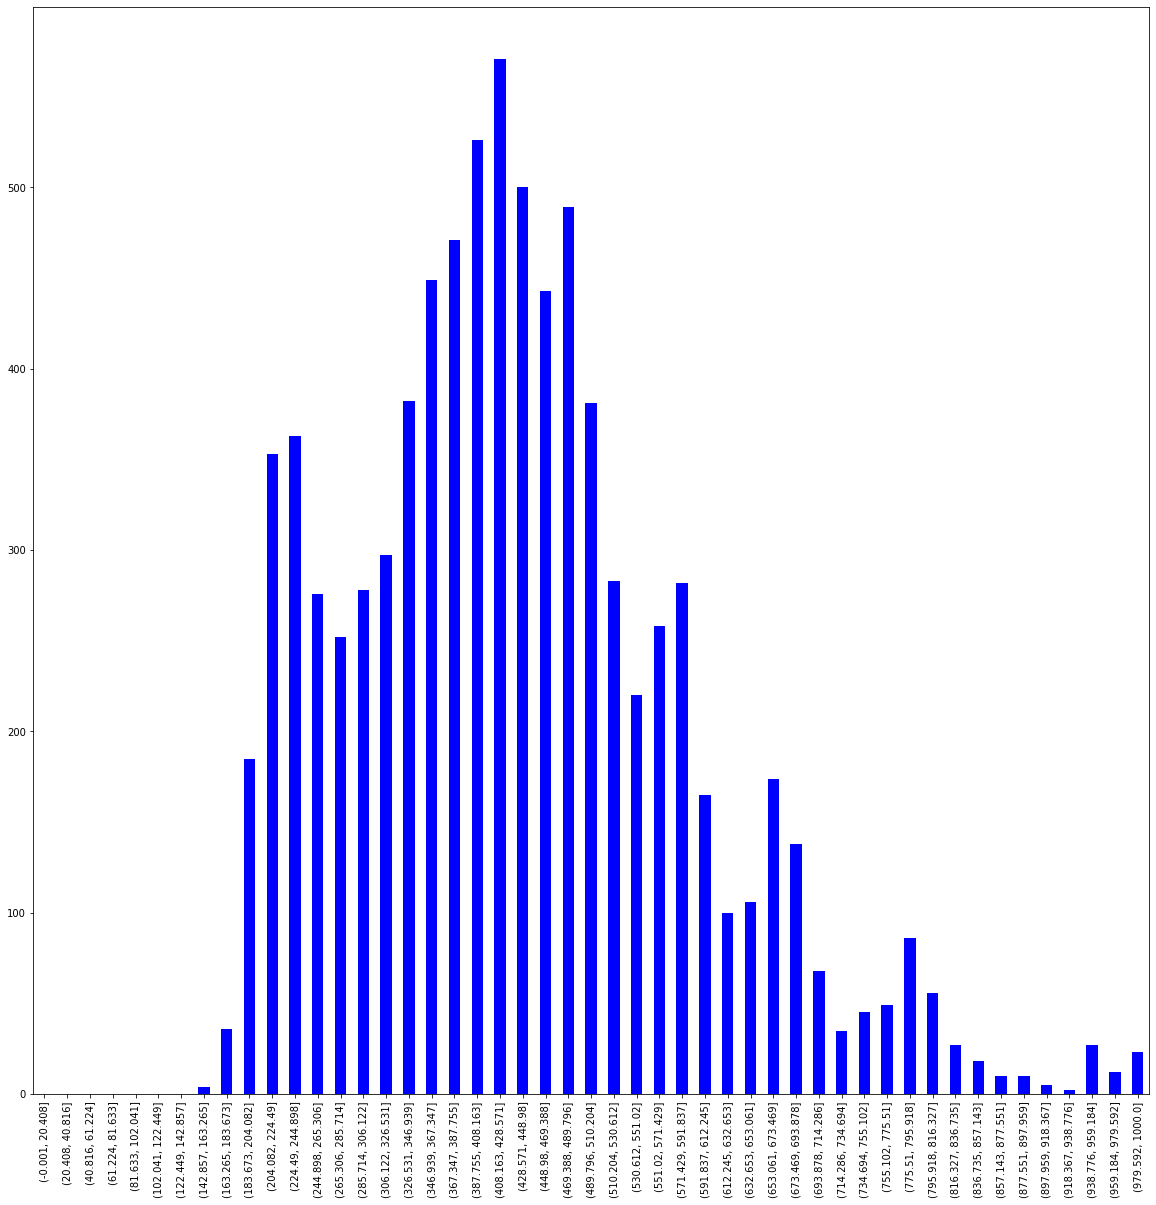

In [ ]:
#@title Mean square error optimization

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error

INFLATION_PER_NODE = 14000 # An approximative takeaway from WAGMIi
dao_allocation = 0.1 #@param {type:"slider", min:0, max:1, step:0.1}
initial_pokt_staked = 800000000  #@param {type:"slider", min:100000000, max:1000000000, step:0.1}
pokt_per_servicer = 15000 #@param {type:"slider", min:10000, max:20000, step:1000}

rmses = []
min_rms = None

best_num_vals = None
best_percent_unstaked_pokt_remaining = None
best_a = None
best_b = None
best_c_target_val_stake = None
best_d_min_val_allocation = None

should_plot = False

vals_range = np.linspace(1000, 5000, 10)
unstaked_pokt_rem_range = np.linspace(0.2, 0.8, 4)
b_range = np.linspace(5, 50, 5)
a_range = np.linspace(0.1, 0.9, 5)
c_range = np.linspace(0.2, 0.8, 4) #target_val_stake_c
d_range = np.linspace(0.1, 0.3, 3) # min_val_allocation_d

for num_vals in vals_range:
  for percent_unstaked_pokt_remaining in unstaked_pokt_rem_range:
    for target_val_stake_c in c_range:
      if target_val_stake_c == 0:
        continue
      for b in b_range:
        for a in a_range:
          for min_val_allocation_d in d_range:
            if a + dao_allocation + min_val_allocation_d > 1:
              continue

            df = get_df(
                num_nodes, initial_pokt_staked, pokt_per_servicer, percent_unstaked_pokt_remaining, INFLATION_PER_NODE, num_vals,
                a, b, target_val_stake_c, min_val_allocation_d,
                ideal_val_a, ideal_val_b, ideal_val_c, ideal_val_d,)
            
            rms = np.sqrt(mean_squared_error(df['ideal_val_serv_delta_apy'], df['val_serv_delta_apy']))
            # rms = np.sqrt(mean_squared_error(df['ideal_val_apy'], df['val_apy']))
            if min_rms == None or rms < min_rms:
                best_num_vals = num_vals
                best_percent_unstaked_pokt_remaining = percent_unstaked_pokt_remaining
                best_a = a
                best_b = b
                best_c_target_val_stake = target_val_stake_c
                best_d_min_val_allocation = min_val_allocation_d
                min_rms = rms
            rmses.append(rms)
            
            if should_plot:
                label = f'|ideal - actual|; {num_vals} vals; {percent_unstaked_pokt_remaining} unstaked rem; {target_val_stake} target_val_stake'
                plot1.plot(df['num_nodes'], df['ideal_val_serv_delta_apy'] - df['val_serv_delta_apy'], label=label)
                plot1.legend()
                plot1.set_xlabel('Num Nodes')
                plot1.set_ylabel('Ideal vs Actual % APY')
                plot1.set_title('Ideal vs Actual % APY vs Num Nodes')

print(min(rmses), max(rmses))

out = pd.cut(rmses, bins=list(np.linspace(0, 1000, 50)), include_lowest=True)
ax = out.value_counts().plot.bar(rot=0, color="b", figsize=(20,20))
plt.xticks(rotation = 90)
plt.show()

best_num_vals: 1000.0 
best_percent_unstaked_pokt_remaining: 0.2 
best_a: 0.5 
best_b: 38.75 
best_c_target_val_stake: 0.2 
best_d_min_val_allocation: 0.2


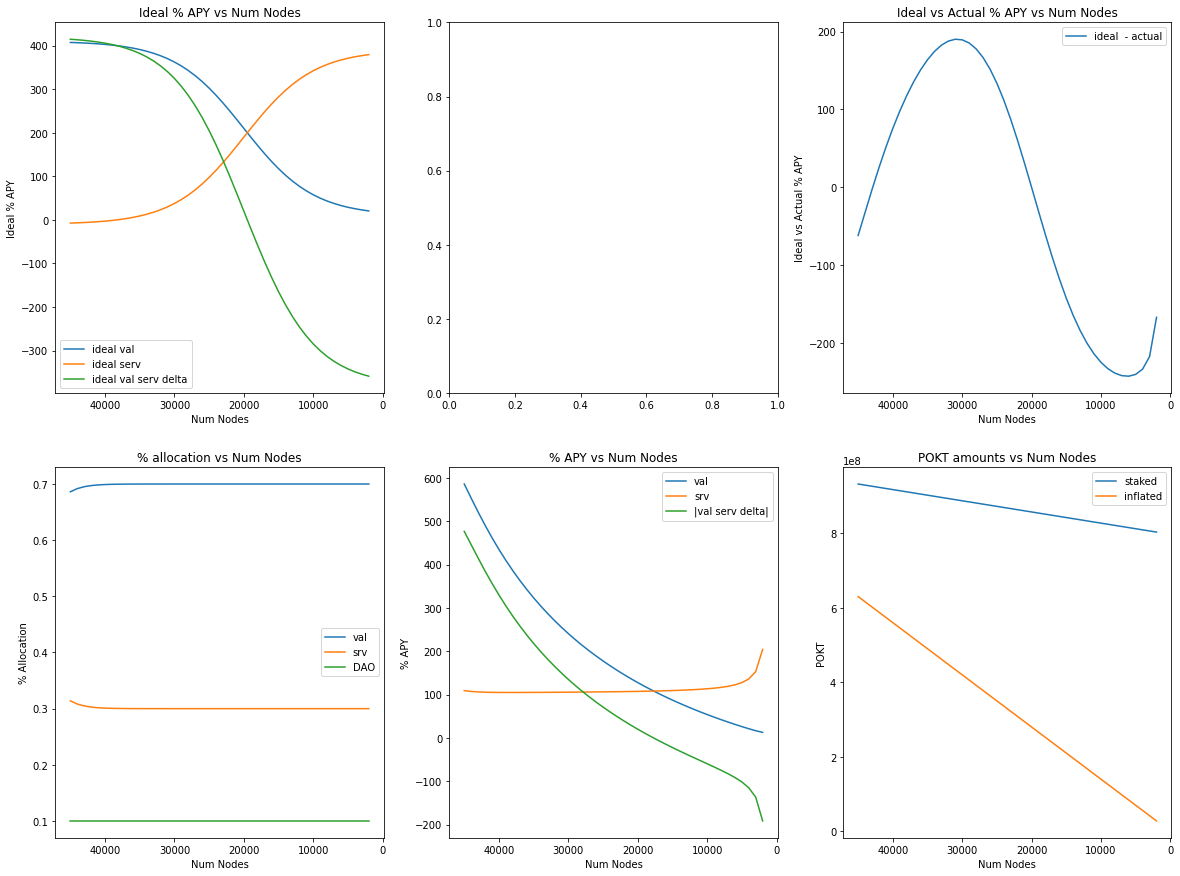

In [ ]:
#@title
print(
    'best_num_vals:', best_num_vals,
    '\nbest_percent_unstaked_pokt_remaining:', best_percent_unstaked_pokt_remaining,
    '\nbest_a:', best_a,
    '\nbest_b:', best_b,
    '\nbest_c_target_val_stake:', best_c_target_val_stake,
    '\nbest_d_min_val_allocation:', best_d_min_val_allocation,
    
)
df = get_df(
    num_nodes, initial_pokt_staked, pokt_per_servicer, best_percent_unstaked_pokt_remaining, INFLATION_PER_NODE, best_num_vals,
    best_a, best_b, best_c_target_val_stake, best_d_min_val_allocation,
    ideal_val_a, ideal_val_b, ideal_val_c, ideal_val_d, 
    )
plot(df)